# Quantifying Mass Transfer between M31 and MW by means of the Jacobi Radius and Hernquist Profiles

The objective of this assignment is to discover which particles composing M31 and MW may transfer between each other, or escape both systems, during close encounters. We can do so by first calculating the Jacobi Radius for a given galaxy, and listing particles belonging to the galaxy that end up outside of the Jacobi radius. From there, we can further check if these particles undergo mass transfer by calculating their kinetic energy, and their analytic gravitational potential energies based on their Hernquist profiles and Miamoto-Nagai profiles. This is assuming that the Hernquist profile still maintains a reasonable shape during these close encounters, so we will also have to calculate Hernquist profiles at snapnumbers of importance. 

In [2]:
#first things first, we need the relevant software that calculates the jacobi radius of a galaxy, as well as other software capable of reading in galaxy info

#we will also need our Hernquist profile code

# import modules
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.constants import G

# import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

# my modules
from ReadFile import Read
from CenterOfMass import CenterOfMass
from MassProfile import MassProfile
from GalaxyMass import ComponentMass
from MassProfile import mEncPlot



In [3]:
#find host mass
def find_host_mass(r,a, Mhalo, Mdisk, Mbulge):
    ''' 
    finds total host mass by summing enclosed Hernquist mass, disk mass, and bulge mass
    inputs:
        r: float, isothermal radius marking the boundary where we include host dark matter, in kpc. 
            It's possible that this should be the separation distance between MW and M31
        a: float, scale factor of host galaxy for the analytic Hernquist profile, in kpc
        Mhalo: float, total halo mass of host galaxy, in units of 10^12Msun
        Mdisk: total disk mass of host galaxy 10^12Msun
        Mbulge: total bulge mass of host galaxy in 10^12Msun
    outputs:
        tot_mass: float, total mass of the host galaxy for the Jacobi radius calculation (in 10^12 Msun)
    '''
    DM_mass = Mhalo * r**2 / (a+r)**2 #uses Hernquist mass equation, keeping in units of 10^12 Msun
    tot_mass = DM_mass + Mdisk + Mbulge
    return tot_mass



#compute the jacobi radius
def Jacobi_radius(Msat, Mhost, r):
    ''' 
    computes the jacobi radius for a galaxy based on the equation R_j = r(M_sat/(2Mhost))^(1/3). 
    As long as Msat and Mhost are in the same units, the units don't matter

    inputs:
        Msat: float, mass of the satellite in arbitrary units. Using total satellite mass 
        (including dark matter which may need to change)
        Mhost: float, mass of host galaxy, including complete disk mass, bulge mass, and dark matter up to 
        the isothermal sphere radius (or center of mass separation). In same arbitrary units as Msat
        r: float, center of mass separation between MW and M31 in kpc

    outputs:
        r_jacobi: float, jacobi radius of the satellite galaxy, beyond which particles may be susceptible to mass loss
    '''
    r_jacobi = r * (Msat / (2*Mhost))**(1/3)
    return r_jacobi


#we need the center of mass separations between MW and M31, which we calculated in HW6
#we stored these values in a file for the 800 snapshots
def RCOM_separation(gal1file, gal2file, time):
    '''
    finds the center of mass separation between MW and M31 at any given time, 
    based on our orbit separation calculation in HW6. A better method is to call the COM class directly
    which I will implement later

    inputs:
        gal1file: str, filename of one galaxy's center of mass evolution over time
        gal2file: str, filename of the other galaxy's center of mass evolution over time
        time: float, time at which we want to calculate the COM position separation, in units of Myr
    outputs:
        separation: float, the separation distance between the two galaxies at the time specified, in kpc
    '''
    g1orbit_data = np.genfromtxt(gal1file,dtype=None,names=True,skip_header=0)
    g2orbit_data = np.genfromtxt(gal2file,dtype=None,names=True,skip_header=0)
    times = g1orbit_data['t']
    index = np.where(abs(times-(time/1000)) < 0.001) #because of rounding, these numbers should be at least this close
    #time is divided by 1000 because these files have time in units of Gyr, but the txt files have time in Myr
    separation = np.sqrt((g1orbit_data['x'][index] - g2orbit_data['x'][index])**2 + 
                         (g1orbit_data['y'][index] - g2orbit_data['y'][index])**2 + 
                         (g1orbit_data['z'][index] - g2orbit_data['z'][index])**2) #distance formula
    return separation

In [4]:
def RotateFrame(posI,velI):
    """a function that will rotate the position and velocity vectors
    so that the disk angular momentum is aligned with z axis. 
    
    PARAMETERS
    ----------
        posI : `array of floats`
             3D array of positions (x,y,z)
        velI : `array of floats`
             3D array of velocities (vx,vy,vz)
             
    RETURNS
    -------
        pos: `array of floats`
            rotated 3D array of positions (x,y,z) such that disk is in the XY plane
        vel: `array of floats`
            rotated 3D array of velocities (vx,vy,vz) such that disk angular momentum vector
            is in the +z direction 
    """
    
    # compute the angular momentum
    L = np.sum(np.cross(posI,velI), axis=0)
    # normalize the vector
    L_norm = L/np.sqrt(np.sum(L**2))


    # Set up rotation matrix to map L_norm to z unit vector (disk in xy-plane)
    
    # z unit vector
    z_norm = np.array([0, 0, 1])
    
    # cross product between L and z
    vv = np.cross(L_norm, z_norm)
    s = np.sqrt(np.sum(vv**2))
    
    # dot product between L and z 
    c = np.dot(L_norm, z_norm)
    
    # rotation matrix
    I = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    v_x = np.array([[0, -vv[2], vv[1]], [vv[2], 0, -vv[0]], [-vv[1], vv[0], 0]])
    R = I + v_x + np.dot(v_x, v_x)*(1 - c)/s**2

    # Rotate coordinate system
    pos = np.dot(R, posI.T).T
    vel = np.dot(R, velI.T).T
    
    return pos, vel
def get_disk_info(filename):
    '''
    This function creates the components of a galaxy's disk particles relative to the center of mass, 
    and velocity components relative to the center of mass. This is useful if we want to rotate the viewing frame to 
    be edge on. 

    inputs:
        filename: string
            -galaxy txt file we want to find the radius and velocity components of
    outputs:
        r: numpy array of x,y,z values of the disk particles
        v: numpy array of vx,vy,vz values of the disk particles
    '''
    COMD = CenterOfMass(filename,2)
    COMP = COMD.COM_P(0.1)
    COMV = COMD.COM_V(COMP[0],COMP[1],COMP[2])

    # Determine positions of disk particles relative to COM 
    xD = COMD.x - COMP[0].value 
    yD = COMD.y - COMP[1].value 
    zD = COMD.z - COMP[2].value 

    # total magnitude
    rtot = np.sqrt(xD**2 + yD**2 + zD**2)

    # Determine velocities of disk particles relatiev to COM motion
    vxD = COMD.vx - COMV[0].value 
    vyD = COMD.vy - COMV[1].value 
    vzD = COMD.vz - COMV[2].value 

    # total velocity 
    vtot = np.sqrt(vxD**2 + vyD**2 + vzD**2)

    # Vectors for r and v 
    r = np.array([xD,yD,zD]).T # transposed 
    v = np.array([vxD,vyD,vzD]).T
    return r, v

In [5]:
def find_outside_particles(r_j, xp,yp,zp, xcom, ycom, zcom):
    ''' 
    creates an array of particles with radii greater than the Jacobi radius, where the radius is 
    the distance from the center of mass of the host galaxy
    inputs: 
        r_j: float, jacobi radius value of satellite galaxy
        xp,yp,zp: each numpy arrays of x,y,z positions of a galaxy's particles
        xcom, ycom, zcom: float values of the galaxy's center of mass position
    outputs:
        outsider_index: numpy array of indices of particles with radii beyond the jacobi radius
    '''
    separations = np.sqrt((xp-xcom)**2 + (yp-ycom)**2 + (zp-zcom)**2)
    outsider_index = np.where(separations > r_j)
    return outsider_index

def find_inside_particles(r_j, xp,yp,zp, xcom, ycom, zcom):
    ''' 
    creates an array of particles with radii less than the Jacobi radius, where the radius is 
    the distance from the center of mass of the host galaxy. Mostly meant for visualization
    inputs: 
        r_j: float, jacobi radius value of satellite galaxy
        xp,yp,zp: each numpy arrays of x,y,z positions of a galaxy's particles
        xcom, ycom, zcom: float values of the galaxy's center of mass position
    outputs:
        insider_index: numpy array of indices of particles with radii beyond the jacobi radius
    '''
    separations = np.sqrt((xp-xcom)**2 + (yp-ycom)**2 + (zp-zcom)**2)
    insider_index = np.where(separations <= r_j)
    return insider_index

In [6]:
def find_ke(vx, vy, vz):
    ''' 
    Function that calculates the specific kinetic energy based on the particle's velocity

    inputs:
        vx: numpy array, x components of particle velocity
        vy: numpy array, y components of particle velocity
        vz: numpy array, z components of particle velocity
    
    outputs:
        ke: numpy array of particle kinetic energies
    '''
    ke = 1/2 * (vx**2 + vy**2 + vz**2)
    return ke

def hernquist_potential(M, a, r):
    ''' 
    function that computes the analytic Hernquist potential based on the formula:
    phi = -GM/(r+a), where M is either halo mass or bulge mass

    inputs:
        M: float, enclosed mass in Msun
        a: float, galaxy scale factor in kpc
        r: float, radius to calculate potential in kpc
    
    outputs:
        phi: float, gravitational potential based on Hernquist profile of either bulge or halo, in units of energy/mass
    '''
    G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
    phi = -G * M / (r + a)
    return phi
def Nagai_potential(Mdisk, x, y, z, rd, zd):
    ''' 
    function that computes the analytic Miamoto-Nagai potential for a disk (see homework 7)

    inputs:
        Mdisk: float, total mass of the disk in Msun
        x,y,z: floats, x, y, and z components of our radius to calculate the potential
        rd: float, disk scale factor in kpc (we assume 5 for now, will probably change)
        zd: float, scale height of disk in kpc. We assume this to be 1/5 of the disk scale factor
    
    outputs:
        phi: float, gravitational potential based on Miamoto-Nagai profile of the disk, in units of energy/mass
    '''
    G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
    R = np.sqrt(x**2 + y**2)
    B = rd + np.sqrt(z**2 + zd**2)
    phi = -G * Mdisk / np.sqrt(R**2 + B**2)
    return phi

In [7]:
def mEncPlot(galaxy, snap, plot_name, a):
    '''
    Plots the total and component-wise mass profile of a galaxy, 
    along with the analytic expectation from the Hernquist profile.

    PARAMETERS
    ----------
    galaxy : `str; 'MW', 'M31', or 'M33'`
        Name of the galaxy to read in
    snap : `int`
        Number of the snapshot to read in
    plot_name : 'str'
        Filename to save the plot under
    a : `float`
        Hernquist scale radius for analytic plot
    '''

    # read in galaxy information
    mProf = MassProfile(galaxy, snap) # mass profile

    # finding filename 
    ilbl = '000' + str(snap) # pad snapshot number
    ilbl = ilbl[-3:] # cut off leading digits so we end up 
      #with a three-digit snap number
    filename='%s_'%(galaxy) + ilbl + '.txt'
        
    M_halo_tot = ComponentMass(filename, 1) * 1e12 * u.Msun 
        # halo mass in Msun

    # radius array in kpc
    r_arr = np.linspace(0.1, 30, 100)

    # calculate mass profiles
    m_halo = mProf.massEnclosed(1, r_arr)
    m_disk = mProf.massEnclosed(2, r_arr)
    if galaxy != 'M33' : 
        # M33 doesn't have a bulge, so skip this if needed
        m_bulge = mProf.massEnclosed(3, r_arr)
    m_tot = mProf.massEnclosedTotal(r_arr)

    # make plot
    fig, ax = plt.subplots()
    # lines
    ax.plot(r_arr, mProf.hernquistMass(r_arr, a, M_halo_tot), 
            c='cyan', label='Analytic Halo, a={} kpc'.format(a))
    ax.plot(r_arr, m_halo, c='b', linestyle=':', label='Halo')
    ax.plot(r_arr, m_disk, c='r', linestyle='-.', label='Disk')
    if galaxy != 'M33' : 
        # M33 doesn't have a bulge, so skip this if needed
        ax.plot(r_arr, m_bulge, c='g', linestyle='--', label='Bulge')
    ax.plot(r_arr, m_tot, c='k', linewidth=3, label='Total')
    # other formatting 
    ax.set(xlabel='r [kpc]', ylabel='$M_{enc}$ $[M_\\odot]$', 
           yscale='log', ylim=[1e8, 5e11], title=galaxy+' Mass Profile')
    ax.legend()
    #save as image
    plt.savefig(plot_name, dpi = 300)

Jacobi radius: $R_j = r  \bigg( \frac{M_{sat}}{2 M_{host}(<r)} \bigg)^{1/3}$

assumptions: satellite is on circular orbit around an isothermal sphere. These are very big assumptions for particles that may not be following circular orbits around interacting galaxies that may not be isothermal spheres, but it does provide a ballpark estimate

For the Milky way, $M_{MW}(<r) = M_{halo} (r) + M_{disk} + M_{bulge}$, $M_{sat} = M_{31\ tot}$, and $r = R_{COM}$ between M31 and MW. Vice versa for M31's Jacobi radius. By the Hernquist profile assumption, $M_{halo}(r) = \frac{M_{halo\ tot} r^2}{(a+r)^2}$

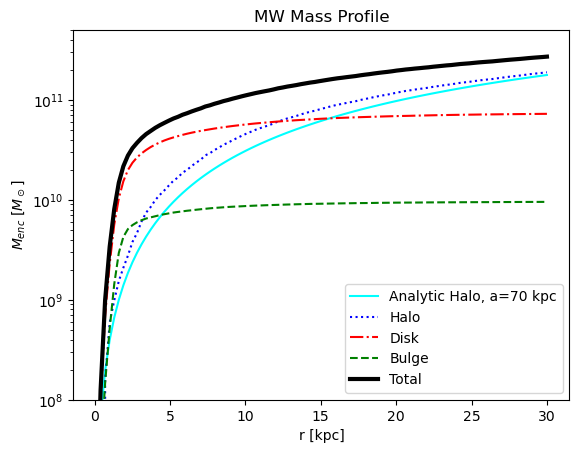

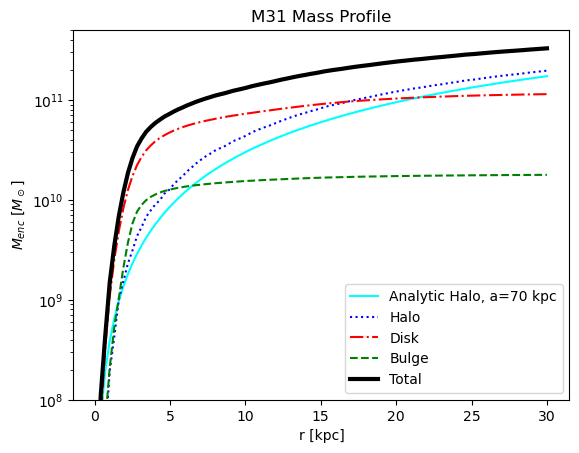

In [9]:
#plot Hernquist profiles to see how accurate they are at 5.8 Gyr
mEncPlot('MW', 410, 'MW_410_mass.png', 70)
mEncPlot('M31', 410, 'M31_410_mass.png', 70)

In [12]:
#mass transfer from MW
#now MW is the satellite, M31 is the host galaxy

MWtime, MWtotal, MWdata = Read('MW_410.txt') #find data for MW at this snapnumber
M31time, M31total, M31data = Read('M31_410.txt') #find data for M31 at this snapnumber

M31_halomass = ComponentMass('M31_410.txt', 1) #recall, units of 10^12 Msun
M31_diskmass = ComponentMass('M31_410.txt', 2) #recall, units of 10^12 Msun
M31_bulgemass = ComponentMass('M31_410.txt', 3) #recall, units of 10^12 Msun
M31_scalefactor = 70 #kpc, from above plot
M31_MW_separation = RCOM_separation('OrbitMW_0_800.txt', 'OrbitM31_0_800.txt', MWtime.value)
#try using massenclosedtotalfunction
M31_hostmass = find_host_mass(M31_MW_separation, M31_scalefactor, M31_halomass, M31_diskmass, M31_bulgemass) #all M31 mass up to the RCOM separation between MW and M31
M31_profile = MassProfile('M31', 410)
MW_profile = MassProfile('MW', 410)
#M31_hostmass = M31_profile.massEnclosedTotal(M31_MW_separation) #units of 10^10 Msun
MW_satmass = ComponentMass('MW_410.txt', 1) + ComponentMass('MW_410.txt', 2) + ComponentMass('MW_410.txt', 3) #we need the total satellite mass
#MW_satmass = MW_profile.massEnclosedTotal(10000)
MW_Jacobi_Rad = Jacobi_radius(MW_satmass, M31_hostmass, M31_MW_separation)
print('MW Jacobi radius is', MW_Jacobi_Rad,  'kpc')


MW Jacobi radius is [14.7308019] kpc


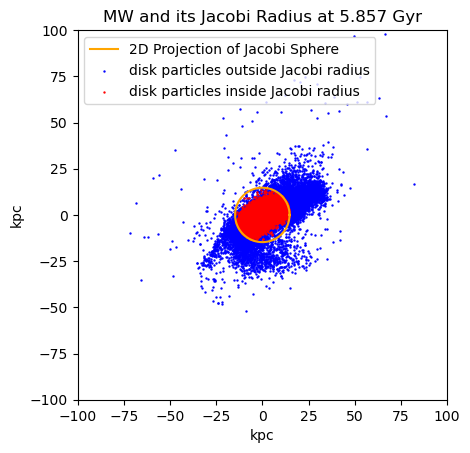

In [14]:
#we need to globally find the x,y,z coordinates of M31's center of mass, similar to our RCOM_separation function
MWorbit_data = np.genfromtxt('OrbitMW_0_800.txt',dtype=None,names=True,skip_header=0)
#M31orbit_data = np.genfromtxt('OrbitM31_0_800.txt',dtype=None,names=True,skip_header=0)
times = MWorbit_data['t']
timenow_index = np.where(abs(times-(MWtime.value/1000)) < 0.001) #because of rounding, these numbers should be at least this close


#we need current time x,y,z values of the center of mass positions and velocities of MW as the satellite galaxy
MW_xcom = MWorbit_data['x'][timenow_index] 
MW_ycom = MWorbit_data['y'][timenow_index]
MW_zcom = MWorbit_data['z'][timenow_index]
MW_vxcom = MWorbit_data['vx'][timenow_index]
MW_vycom = MWorbit_data['vy'][timenow_index]
MW_vzcom = MWorbit_data['vz'][timenow_index]

#we'll check disk particles now
disk_index = np.where(MWdata['type'] == 2) #isolating all disk particles
xs = MWdata['x'][disk_index]
ys = MWdata['y'][disk_index]
zs = MWdata['z'][disk_index]


MW_outside_index = find_outside_particles(MW_Jacobi_Rad, xs,ys,zs, MW_xcom, MW_ycom, MW_zcom) #indices of outside jacobi radius disk particles
MW_inside_index = find_inside_particles(MW_Jacobi_Rad, xs,ys,zs, MW_xcom, MW_ycom, MW_zcom) #indices of inside jacobi radius disk particles


fig, ax = plt.subplots()
######## draw a circle with jacobi radius to represent all particles inside it
angle = np.linspace( 0 , 2 * np.pi , 150 ) 
radius = MW_Jacobi_Rad
x = radius * np.cos( angle ) 
y = radius * np.sin( angle )
ax.plot(x,y, c = 'orange', label = '2D Projection of Jacobi Sphere')
#######


r_MW, v_MW = get_disk_info('MW_410.txt') #to create face on plots of MW for better visualization
ax.scatter(r_MW[:,0][MW_outside_index], r_MW[:,2][MW_outside_index], s = 0.5, c = 'blue', label = 'disk particles outside Jacobi radius')
ax.scatter(r_MW[:,0][MW_inside_index], r_MW[:,2][MW_inside_index], s = 0.5, c = 'red',label = 'disk particles inside Jacobi radius' )
ax.legend(loc = 'upper left')
ax.set_ylim(-100,100)
ax.set_xlim(-100,100)
ax.set_xlabel('kpc')
ax.set_ylabel('kpc')
ax.set_title('MW and its Jacobi Radius at 5.857 Gyr')
ratio = 1.0 #to make the plot scaled properly so there is no stretching or compressing
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
plt.savefig("MW410_disk", dpi=300)
plt.show()

particle_radii = np.sqrt((MW_xcom - xs[MW_outside_index])**2 + (MW_ycom - ys[MW_outside_index])**2 + (MW_zcom - zs[MW_outside_index])**2) #outside disk particle radius values
all_particle_radii = np.sqrt((MW_xcom - xs)**2 + (MW_ycom - ys)**2 + (MW_zcom - zs)**2) #all disk particle radius values


In [15]:
MW_rdisk = 5 #units of kpc, scale length of M31 disk
z_disk = MW_rdisk / 5 #we might need to change these values depending on how deformed the galaxies get


#we need the mass of all galaxy components to calculate our potential energies
MW_halomass = ComponentMass('MW_410.txt', 1) * 10**12 
MW_diskmass = ComponentMass('MW_410.txt', 2) * 10**12
MW_bulgemass = ComponentMass('MW_410.txt', 3) * 10**12


#kinetic energies of outside particles
outside_KE_list = find_ke(MWdata['vx'][disk_index][MW_outside_index] - MW_vxcom, MWdata['vy'][disk_index][MW_outside_index] - MW_vycom, MWdata['vz'][disk_index][MW_outside_index] - MW_vzcom)
outside_particle_radii = np.sqrt((MW_xcom - xs[MW_outside_index])**2 + (MW_ycom - ys[MW_outside_index])**2 + (MW_zcom - zs[MW_outside_index])**2)




#calculate the potential energies from the disk, halo, and bulge for all of these outside particles
outside_halo_potential = hernquist_potential(MW_halomass, 70, outside_particle_radii)
outside_bulge_potential = hernquist_potential(MW_bulgemass, 70, outside_particle_radii)
outside_nagai_potential = Nagai_potential(MW_diskmass, xs[MW_outside_index], ys[MW_outside_index], zs[MW_outside_index], MW_rdisk, z_disk)

#sum the potential energies together for all of these outside particles
tot_potential = outside_halo_potential + outside_bulge_potential + outside_nagai_potential
energies = outside_KE_list + tot_potential


pos_energy_index = np.where(energies > 0) #index of all DISK particles with energies greater than zero
neg_energy_index = np.where(energies < 0) #index of all DISK particles with energies less than zero
mass_transfer_list = MWdata['m'][disk_index][MW_outside_index][pos_energy_index] #masses of outside disk particles that have energies greater than zero
tot_outside_mass =  np.sum(MWdata['m'][disk_index][MW_outside_index]) #summing all this outside mass together
tot_disk_mass = np.sum(MWdata['m'][disk_index]) #finding total disk mass as a comparison
tot_mass_transfer =  np.sum(mass_transfer_list) #summing together all outside disk mass with energy greater than zero
print('total disk mass is', tot_disk_mass, '*10^10 Msun, total outside disk mass is', tot_outside_mass, '*10^10 Msun, total mass transferred is', tot_mass_transfer, '*10^10 Msun')


total disk mass is 7.500000000000003 *10^10 Msun, total outside disk mass is 1.0559000000000003 *10^10 Msun, total mass transferred is 0.07130000000000002 *10^10 Msun


In [16]:
#find kinetic energies of inside particles, adjusting their kinetic energies relative to the center of mass of the satellite galaxy disk
inside_KE_list = find_ke(MWdata['vx'][disk_index][MW_inside_index] - MW_vxcom, MWdata['vy'][disk_index][MW_inside_index] - MW_vycom, MWdata['vz'][disk_index][MW_inside_index] - MW_vzcom)

#finding radii of particles inside the Jacobi radius for the potential energy calculations
inside_particle_radii = np.sqrt((MW_xcom - xs[MW_inside_index])**2 + (MW_ycom - ys[MW_inside_index])**2 + (MW_zcom - zs[MW_inside_index])**2)

#repeating same calculation as above, but now for particles inside the Jacobi radius
inside_halo_potential = hernquist_potential(MW_halomass, 70, inside_particle_radii) #hernquist halo potential for particles inside jacobi radius
inside_bulge_potential = hernquist_potential(MW_bulgemass, 70, inside_particle_radii) #hernquist bulge potential for particles inside jacobi radius
inside_nagai_potential = Nagai_potential(MW_diskmass, xs[MW_inside_index], ys[MW_inside_index], zs[MW_inside_index], MW_rdisk, z_disk) #miamoto-nagai potential for particles inside jacobi radius

tot_inside_potential = inside_halo_potential + inside_bulge_potential + inside_nagai_potential #summing all potentials together for each outside particle
energies = inside_KE_list + tot_inside_potential #add kinetic and potential energy together
pos_energy_index = np.where(energies > 0)
mass_transfer_list = MWdata['m'][disk_index][MW_inside_index][pos_energy_index]
tot_inside_mass =  np.sum(MWdata['m'][disk_index][MW_inside_index])
tot_mass_transfer = np.sum(mass_transfer_list)
print('total mass inside the Jacobi radius is', tot_inside_mass,  '*10^10 Msun, and total positive energy mass inside the Jacobi radius is', tot_mass_transfer, '*10^10 Msun')


total mass inside the Jacobi radius is 6.4441000000000015 *10^10 Msun, and total positive energy mass inside the Jacobi radius is 0.16070000000000004 *10^10 Msun


let's see these particles at 7.1 Gyr...

In [13]:

laterMWtime, laterMWtotal, laterMWdata = Read('MW_500.txt') #find data for MW at this snapnumber (7.1 Gyr)
laterM31time, laterM31total, laterM31data = Read('M31_500.txt') #find data for M31 at this snapnumber (7.1 Gyr)
M31orbit_data = np.genfromtxt('OrbitM31_0_800.txt',dtype=None,names=True,skip_header=0)
times = M31orbit_data['t']
timenow_index = np.where(abs(times-(laterM31time.value/1000)) < 0.001) #because of rounding, these numbers should be at least this close



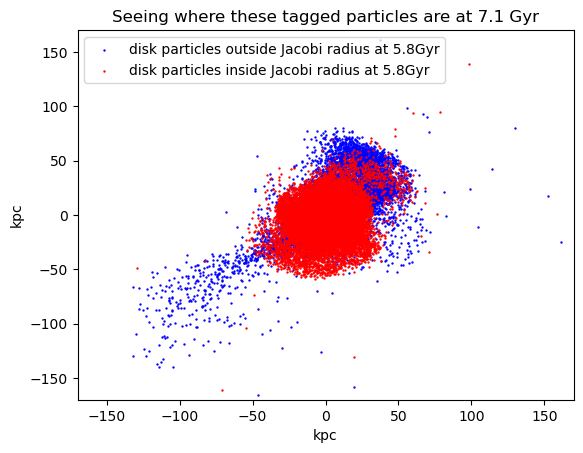

In [176]:
fig, ax = plt.subplots()
later_r_MW, new_v_MW = get_disk_info('MW_500.txt') #rotating these particles to be face on
#plotting particles outside Jacobi radius at a later time
ax.scatter(later_r_MW[:,0][MW_outside_index], later_r_MW[:,2][MW_outside_index], s = 0.5, c = 'blue', label = 'disk particles outside Jacobi radius at 5.8Gyr')
ax.scatter(later_r_MW[:,0][MW_inside_index], later_r_MW[:,2][MW_inside_index], s = 0.5, c = 'red',label = 'disk particles inside Jacobi radius at 5.8Gyr' )
ax.legend(loc = 'upper left')
ax.set_ylim(-170,170)
ax.set_xlim(-170,170)
ax.set_xlabel('kpc')
ax.set_ylabel('kpc')
ax.set_title('Seeing where these tagged particles are at 7.1 Gyr')
plt.show()

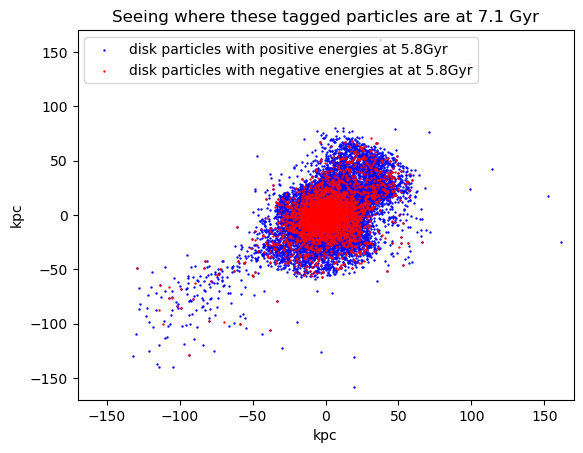

In [33]:
fig, ax = plt.subplots()
#plotting particles with positive and negative energies at a later time
ax.scatter(later_r_MW[:,0][pos_energy_index], later_r_MW[:,2][pos_energy_index], s = 0.5, c = 'blue', label = 'disk particles with positive energies at 5.8Gyr')
ax.scatter(later_r_MW[:,0][neg_energy_index], later_r_MW[:,2][neg_energy_index], s = 0.5, c = 'red',label = 'disk particles with negative energies at at 5.8Gyr' )
ax.legend(loc = 'upper left')
ax.set_ylim(-170,170)
ax.set_xlim(-170,170)
ax.set_xlabel('kpc')
ax.set_ylabel('kpc')
ax.set_title('Seeing where these tagged particles are at 7.1 Gyr')
plt.show()

Let's Repeat these exact steps, but now treating M31 as the satellite galaxy and MW as the host galaxy. Would like to compress this down into a function later to reduce the amount of lines taken up in the code.

In [182]:
MW_halomass = ComponentMass('MW_410.txt', 1) #recall, units of 10^12 Msun
MW_diskmass = ComponentMass('MW_410.txt', 2) #recall, units of 10^12 Msun
MW_bulgemass = ComponentMass('MW_410.txt', 3) #recall, units of 10^12 Msun


#satellite mass, using every mass component completely
M31_satmass = ComponentMass('M31_410.txt', 1) + ComponentMass('M31_410.txt', 2) + ComponentMass('M31_410.txt', 3) #recall, units of 10^12 Msun

M31_MW_separation = RCOM_separation('OrbitMW_0_800.txt', 'OrbitM31_0_800.txt', MWtime.value)
snap400_MW_scalefactor = 70
MW_hostmass = find_host_mass(M31_MW_separation, snap400_MW_scalefactor, MW_halomass, MW_diskmass, MW_bulgemass)
M31_jacobi_rad = Jacobi_radius(M31_satmass, MW_hostmass, M31_MW_separation)

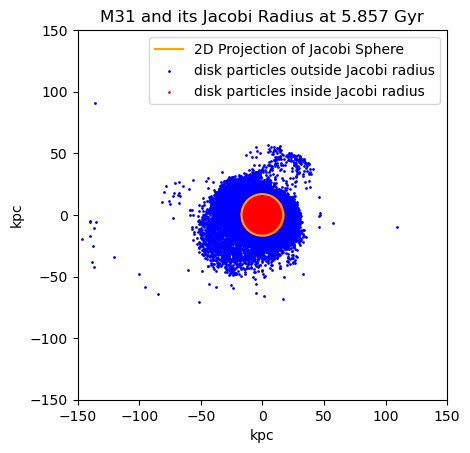

In [187]:
r_M31, v_M31 = get_disk_info('M31_410.txt')
rn_M31, vn_M31 = RotateFrame(r_M31, v_M31)
M31orbit_data = np.genfromtxt('OrbitM31_0_800.txt',dtype=None,names=True,skip_header=0)
times = M31orbit_data['t']
timenow_index = np.where(abs(times-(M31time.value/1000)) < 0.001) #because of rounding, these numbers should be at least this close

#we need the center of mass position and speed components for our energy calulations
M31_xcom = M31orbit_data['x'][timenow_index]
M31_ycom = M31orbit_data['y'][timenow_index]
M31_zcom = M31orbit_data['z'][timenow_index]
M31_vxcom = M31orbit_data['vx'][timenow_index]
M31_vycom = M31orbit_data['vy'][timenow_index]
M31_vzcom = M31orbit_data['vz'][timenow_index]

#we'll check disk particles now
M31disk_index = np.where(M31data['type'] == 2)
M31_xs = M31data['x'][M31disk_index]
M31_ys = M31data['y'][M31disk_index]
M31_zs = M31data['z'][M31disk_index]

#index representing all DISK particles of M31 that are OUTSIDE of the calculated Jacobi radius
M31_outside_index = find_outside_particles(M31_jacobi_rad, M31_xs,M31_ys,M31_zs, M31_xcom, M31_ycom, M31_zcom)

#index representing all DISK particles of M31 that are INSIDE of the calculated Jacobi radius
M31_inside_index = find_inside_particles(M31_jacobi_rad, M31_xs,M31_ys,M31_zs, M31_xcom, M31_ycom, M31_zcom)

#projecting the Jacobi radius by plotting a circle with the radius of the Jacobi radius
angle = np.linspace( 0 , 2 * np.pi , 150 ) 
radius = M31_jacobi_rad
x = radius * np.cos( angle ) 
y = radius * np.sin( angle )

fig, ax = plt.subplots()
ax.plot(x,y, c = 'orange', label = '2D Projection of Jacobi Sphere') #plotting the Jacobi radius circle
ax.scatter(r_M31[:,0][M31_outside_index], r_M31[:,2][M31_outside_index], s = 1, c = 'blue', label = 'disk particles outside Jacobi radius') #rotated coords, but only outside particles
ax.scatter(r_M31[:,0][M31_inside_index], r_M31[:,2][M31_inside_index], s = 1, c = 'red',label = 'disk particles inside Jacobi radius' ) #rotated coords, but only inside particles
ax.legend()
ax.set_ylim(-150,150)
ax.set_xlim(-150,150)
ax.set_xlabel('kpc')
ax.set_ylabel('kpc')
ax.set_title('M31 and its Jacobi Radius at 5.857 Gyr')
ratio = 1.0 #adjusting the ratio so x and y axes are the same length
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

plt.savefig("M31_410_disk", dpi=300)
plt.show()

particle_radii = np.sqrt((M31_xcom - M31_xs[M31_outside_index])**2 + (M31_ycom - M31_ys[M31_outside_index])**2 + (M31_zcom - M31_zs[M31_outside_index])**2)
all_particle_radii = np.sqrt((M31_xcom - M31_xs)**2 + (M31_ycom - M31_ys)**2 + (M31_zcom - M31_zs)**2)

In [102]:
M31_rdisk = 5 #units of kpc, scale length of M31 disk
z_disk = M31_rdisk / 5 #we might need to change these values depending on how deformed the galaxies get

#same exact calculation of energies, but flipping MW with M31 values

M31_halomass = ComponentMass('M31_410.txt', 1) * 10**12
M31_diskmass = ComponentMass('M31_410.txt', 2) * 10**12
M31_bulgemass = ComponentMass('M31_410.txt', 3) * 10**12

outside_KE_list = find_ke(M31data['vx'][M31disk_index][M31_outside_index] - M31_vxcom, M31data['vy'][M31disk_index][M31_outside_index] - M31_vycom, M31data['vz'][M31disk_index][M31_outside_index] - M31_vzcom)
outside_particle_radii = np.sqrt((M31_xcom - M31_xs[M31_outside_index])**2 + (M31_ycom - M31_ys[M31_outside_index])**2 + (M31_zcom - M31_zs[M31_outside_index])**2)


outside_halo_potential = hernquist_potential(M31_halomass, 70, outside_particle_radii) #hernquist halo potential for particles outside jacobi radius
outside_bulge_potential = hernquist_potential(M31_bulgemass, 70, outside_particle_radii) #hernquist bulge potential for particles outside jacobi radius
outside_nagai_potential = Nagai_potential(M31_diskmass, M31_xs[M31_outside_index], M31_ys[M31_outside_index], M31_zs[M31_outside_index], M31_rdisk, z_disk) #miamoto-nagai potential

outside_tot_potential = outside_halo_potential + outside_bulge_potential + outside_nagai_potential #sum all potentials together for each particle outside jacobi radius
energies = outside_KE_list + outside_tot_potential #sum kinetic and potential energy together
pos_energy_index = np.where(energies > 0) #particles outside of the Jacobi radius with positive energies
mass_transfer_list = M31data['m'][M31disk_index][M31_outside_index][pos_energy_index] #mass list of M31 disk particles that are outside of the Jacobi radius
tot_outside_mass =  np.sum(M31data['m'][M31disk_index][M31_outside_index])
tot_disk_mass = np.sum(M31data['m'][M31disk_index])
tot_mass_transfer =  np.sum(mass_transfer_list)
print(tot_disk_mass, tot_outside_mass, tot_mass_transfer)

12.000000000000004 2.354800000000001 0.028100000000000007


In [105]:
inside_KE_list = find_ke(M31data['vx'][M31disk_index][M31_inside_index] - M31_vxcom, M31data['vy'][M31disk_index][M31_inside_index] - M31_vycom, M31data['vz'][M31disk_index][M31_inside_index] - M31_vzcom)
inside_particle_radii = np.sqrt((M31_xcom - M31_xs[M31_inside_index])**2 + (M31_ycom - M31_ys[M31_inside_index])**2 + (M31_zcom - M31_zs[M31_inside_index])**2)


inside_halo_potential = hernquist_potential(M31_halomass, 70, inside_particle_radii)
inside_ulge_potential = hernquist_potential(M31_bulgemass, 70, inside_particle_radii)
inside_nagai_potential = Nagai_potential(M31_diskmass, M31_xs[M31_inside_index], M31_ys[M31_inside_index], M31_zs[M31_inside_index], M31_rdisk, z_disk)

inside_tot_potential = inside_halo_potential + inside_bulge_potential + inside_nagai_potential
energies = inside_KE_list + tot_potential
M31_pos_energy_index = np.where(energies > 0) #inside particles with energies greater than zero
M31_neg_energy_index = np.where(energies < 0) #inside particles with energies less than zero
mass_transfer_list = M31data['m'][M31disk_index][M31_inside_index][M31_pos_energy_index]
tot_inside_mass =  np.sum(M31data['m'][M31disk_index][M31_inside_index])
tot_disk_mass = np.sum(M31data['m'][M31disk_index])
tot_mass_transfer =  np.sum(mass_transfer_list)
print(tot_disk_mass, tot_inside_mass, tot_mass_transfer)

12.000000000000004 9.645200000000003 0.2929000000000001


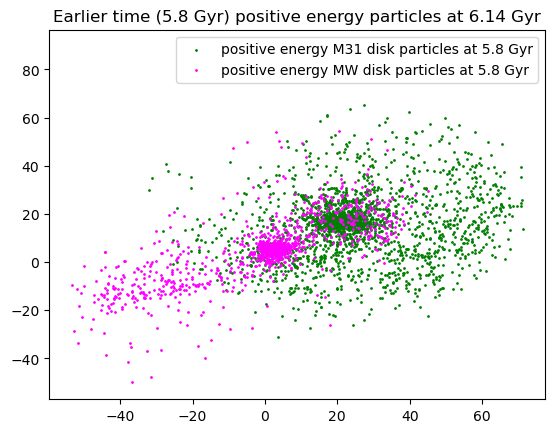

In [188]:
laterMWtime, laterMWtotal, laterMWdata = Read('MW_430.txt') #find data for MW at this snapnumber, representing maximum separation distance after 3rd close encounter
laterM31time, laterM31total, laterM31data = Read('M31_430.txt') #find data for M31 at this snapnumber
laterMWdisk_index = np.where(laterMWdata['type'] == 2)
laterM31disk_index = np.where(laterM31data['type'] == 2)

#make plots of MW and M31 positive energy particles at a later time
fig, ax = plt.subplots()
ax.scatter(laterM31data['x'][laterM31disk_index][M31_pos_energy_index],laterM31data['z'][laterM31disk_index][M31_pos_energy_index], s = 1, c = 'green', label = 'positive energy M31 disk particles at 5.8 Gyr')
ax.scatter(laterMWdata['x'][laterMWdisk_index][pos_energy_index], laterMWdata['z'][laterMWdisk_index][pos_energy_index], s = 1, c = 'magenta', label = 'positive energy MW disk particles at 5.8 Gyr')
plt.title('Earlier time (5.8 Gyr) positive energy particles at 6.14 Gyr')
plt.legend()
plt.show()


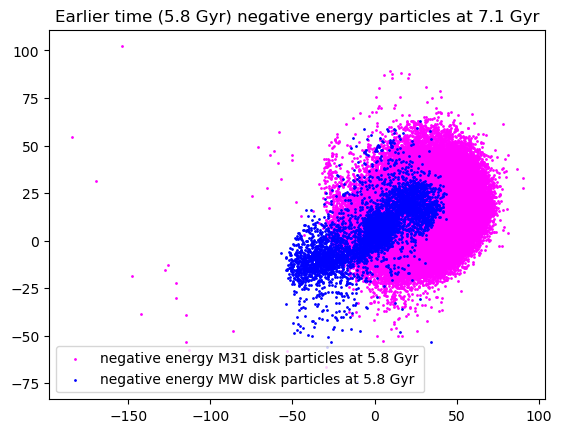

In [190]:
#plotting negative energy particles at later times
fig, ax = plt.subplots()
ax.scatter(laterM31data['x'][laterM31disk_index][M31_neg_energy_index], laterM31data['z'][laterM31disk_index][M31_neg_energy_index], s = 1, c = 'magenta', label = 'negative energy M31 disk particles at 5.8 Gyr')
ax.scatter(laterMWdata['x'][laterMWdisk_index][neg_energy_index], laterMWdata['z'][laterMWdisk_index][neg_energy_index], s = 1, c = 'blue', label = 'negative energy MW disk particles at 5.8 Gyr')
plt.title('Earlier time (5.8 Gyr) negative energy particles at 6.14 Gyr')
plt.legend()
plt.show()

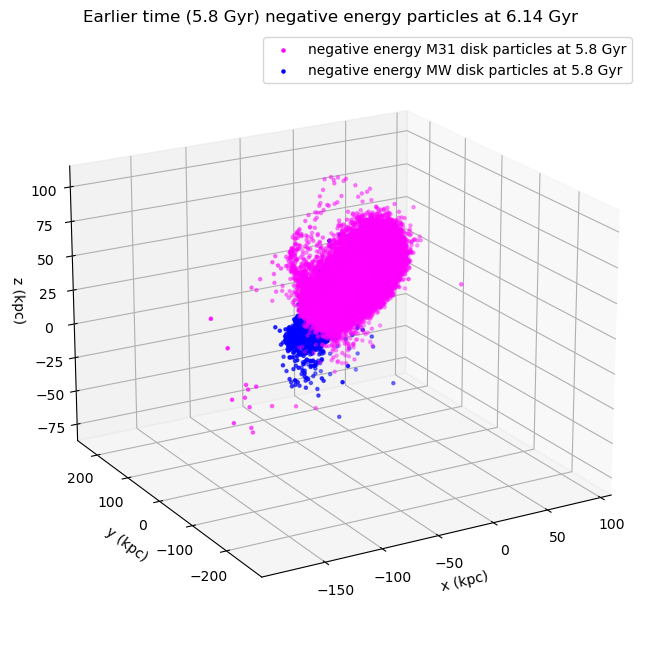

In [191]:
#let's try these same plots of negative energy particles at later times, but in 3d now, instead of 2d face on plots
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(laterM31data['x'][laterM31disk_index][M31_neg_energy_index], laterM31data['y'][laterM31disk_index][M31_neg_energy_index], laterM31data['z'][laterM31disk_index][M31_neg_energy_index], s = 5, c = 'magenta', label = 'negative energy M31 disk particles at 5.8 Gyr')
ax.scatter(laterMWdata['x'][laterMWdisk_index][neg_energy_index], laterMWdata['y'][laterMWdisk_index][neg_energy_index], laterMWdata['z'][laterMWdisk_index][neg_energy_index], s = 5, c = 'blue', label = 'negative energy MW disk particles at 5.8 Gyr')
ax.set_xlabel('x (kpc)')
ax.set_ylabel('y (kpc)')
ax.set_zlabel('z (kpc)')
plt.title('Earlier time (5.8 Gyr) negative energy particles at 6.14 Gyr')
ax.view_init(20, -120)
plt.legend()
plt.savefig("3d_430_negative_disk", dpi=300)
plt.show()

75000


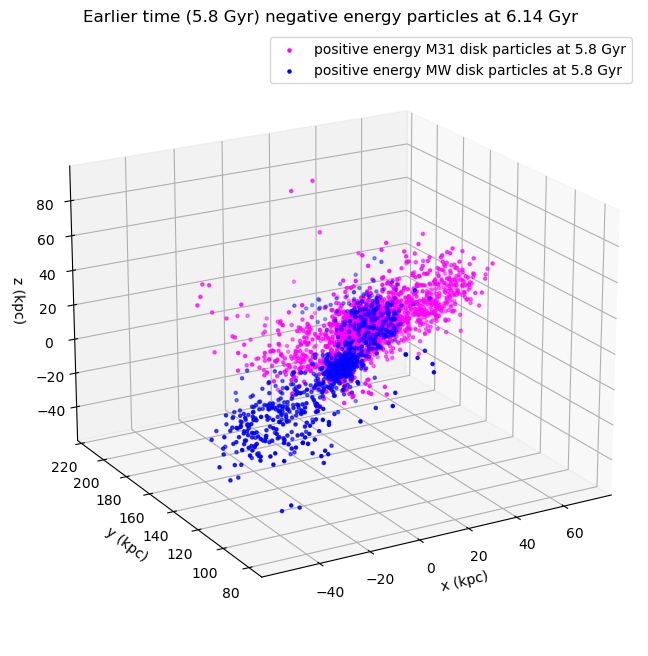

In [192]:
#let's try these same plots of positive energy particles at later times, but in 3d now, instead of 2d face on plots
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection='3d')
print(len(laterMWdata['x'][laterMWdisk_index]))
ax.scatter(laterM31data['x'][laterM31disk_index][M31_pos_energy_index], laterM31data['y'][laterM31disk_index][M31_pos_energy_index], laterM31data['z'][laterM31disk_index][M31_pos_energy_index], s = 5, c = 'magenta', label = 'positive energy M31 disk particles at 5.8 Gyr')
ax.scatter(laterMWdata['x'][laterMWdisk_index][pos_energy_index], laterMWdata['y'][laterMWdisk_index][pos_energy_index], laterMWdata['z'][laterMWdisk_index][pos_energy_index], s = 5, c = 'blue', label = 'positive energy MW disk particles at 5.8 Gyr')
plt.title('Earlier time (5.8 Gyr) negative energy particles at 6.14 Gyr')
ax.set_xlabel('x (kpc)')
ax.set_ylabel('y (kpc)')
ax.set_zlabel('z (kpc)')
ax.view_init(20, -120)
plt.legend()
plt.savefig("3d_430_positive_disk", dpi=300)
plt.show()